In [1]:
import sys
print('sys')
# sys.path.append("C:\\Users\\infinigru\\Anaconda3\\envs\\prac\\lib\\site-packages")
import os
print('os')
import numpy as np
import tensorflow as tf
print('tensorflow :',tf.__version__)
from sklearn import metrics
from sklearn.metrics import confusion_matrix
sys.path = ["C:\\Users\\infinigru\\Anaconda3\\envs\\prac\\lib\\site-packages"] + sys.path
from config import *
from utils.util import *
from model import *
from iterator import DataGenerator

sys
os
tensorflow : 1.13.1


In [2]:
opts = TrainOption('cls')

In [8]:
test_iterator = DataGenerator(TEST_IMAGE, MASK_LOC
                                  ,opts.BATCH_SIZE,IMAGE_SHAPE, OPTIC_DISC_SHAPE
                                  ,is_train=False, copy = False, sample=None)

 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400 Done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.]
V0167.jpg


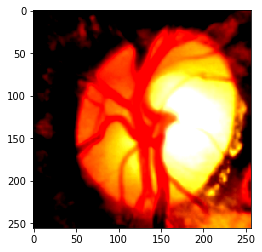

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.]
V0035.jpg


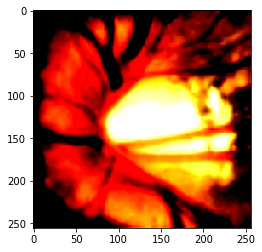

'V0109.jpg'

In [37]:
# print(imgs.shape)

test_images, test_labels,name = test_iterator.get_item()
print(test_labels[0])
print(name[0])
plt.imshow(test_images[0])
plt.show()

print(test_labels[1])
print(name[1])
plt.imshow(test_images[1])
plt.show()
'''V0109.jpg'''

In [3]:
# with open(os.path.join(RESULT_PATH,"history.csv"),'w') as f:
#     f.write("epoch,loss,acc,val_loss,val_acc\n")
import pandas as pd
hist = pd.read_csv(os.path.join(RESULT_PATH,"history.csv"))

In [4]:
hist.tail()

,epoch,loss,auc,val_loss,val_auc
21,25,0.201519,0.975995,1.659619,0.631458
22,26,0.203729,0.975015,1.701945,0.634653
23,27,0.182670,0.981790,1.573303,0.628264
24,28,0.181036,0.982083,1.691138,0.628611
25,29,0.196692,0.976289,1.745869,0.631042


C:\Users\infinigru\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


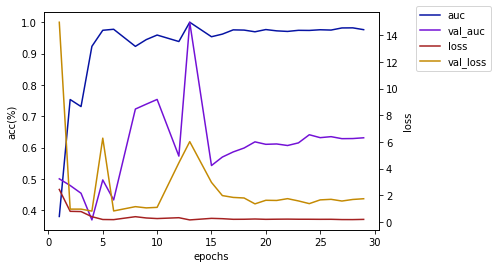

In [5]:
history_graph(hist,metics='auc')

In [6]:
def auc_function(y_target, y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y_target, y_pred, pos_label=1)
    return metrics.auc(fpr, tpr) 

In [7]:
with tf.device('/device:GPU:0'):
    # placeholder for images
    shapes = list((None,)+OPTIC_DISC_SHAPE)
    images = tf.placeholder('float32', shape=shapes, name='images')  
    
    # placeholder for labels
    labels = tf.placeholder('float32', shape=[None, 1], name='labels')  
    
    # placeholder for training boolean (is training)
    training = tf.placeholder('bool', name='training') 
    ## placeholder fot store Beat accuracy
    best_score = tf.get_variable(name='best_accuracy', dtype='float32', trainable=False, initializer=0.0)
#     best_auc = 0
    # model build
    with tf.variable_scope('build'):
        output = ResNetV2(training).build(images)

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.average_pooling2d instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.


In [8]:
with tf.variable_scope('losses'):
    loss = tf.keras.backend.binary_crossentropy(labels, output)
    loss = tf.reduce_mean(loss, name='loss')

In [9]:
graph = tf.get_default_graph()

In [10]:
# saver = tf.train.import_meta_graph(restore_meta)

In [11]:
# for i in graph.get_operations():
#     if 'output-layer' in str(i):
#         print(i)

In [12]:
RESULT_PATH

'D:\\Projects\\my_Glaucoma_project_v2\\result'

In [13]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint(RESULT_PATH))
    
    print(f"test data from : {TEST_IMAGE}")
    test_iterator = DataGenerator(TEST_IMAGE, MASK_LOC
                                  ,opts.BATCH_SIZE,IMAGE_SHAPE, OPTIC_DISC_SHAPE
                                  ,is_train=False, copy = False, sample=None)
    
    # get tensor for feed forward    
#     graph = tf.get_default_graph()
#     images = graph.get_tensor_by_name('images:0')
    
    val_loss = []
    val_acc = np.array([])

    val_y_pred = np.array([])
    val_y_target = np.array([])
    imgs = np.zeros((1,) + IMAGE_SHAPE)
        
    pr=progress()
    i = 0
        
    print(""" testing """)
    while True:
        i += 1
        pr.print_progress(1,len(test_iterator)+1,' ')
        try:
            test_images, test_labels,name = test_iterator.get_item()
            loss_, output_= sess.run([loss, output]
                                     , feed_dict={images: test_images, labels: test_labels
                                   , training: False})
            ## losses
            val_loss.append(loss_)

            val_y_pred = np.append(val_y_pred , np.array(output_).flatten())
            val_y_target = np.append(val_y_target , np.array(test_labels).flatten())

            ## accuracy
            #equal = np.equal(np.argmax(output_,axis =1) , np.argmax(train_labels,axis =1))
            equal = np.equal(val_y_pred>0.5, val_y_target)
            val_acc =np.append(val_acc, equal)        
            
#             for i in range(args.BATCH_SIZE):
#                 if float(output_[i]>0.5) != test_labels[i]:
#                     testimg = test_images[i].reshape((1,)+IMAGE_SHAPE)
#                     imgs = np.vstack([imgs,testimg])
                    
        except IndexError:
            test_iterator.initialize()
            break
        
    mean_val_loss = np.mean(val_loss)
    mean_val_acc = np.mean(val_acc)
    print(f"\t- val loss : {mean_val_loss:5.5f}\t- val acc : {mean_val_acc:5.5f}")

    ## auc 
    val_auc = auc_function(val_y_target, val_y_pred)

    print(f"\tvalidation auc : {val_auc:1.5f}",'\tbest :', best_score.eval() )

    print('validation confustion_matrix')
    print_confusion_matrix(val_y_target,val_y_pred,0.5)
        
#         imgs = imgs[1:]
#         if i> 50:
#             break
            
    sess.close()
# 출처: https://goodtogreate.tistory.com/entry/Saving-and-Restoring [GOOD to GREAT]

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from D:\Projects\my_Glaucoma_project_v2\result\checkpoint_29.ckpt
test data from : D:\Projects\my_Glaucoma_project_v2\dataset\Glaucoma\Test
 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400 Done
 testing 
 [____________________________________________________________________________________________________]   Done

C:\Users\infinigru\Anaconda3\envs\prac\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]   Done	- val loss : 1.08396	- val acc : 0.58512
	validation auc : 0.66736 	best : 0.6346528
validation confustion_matrix
0.5000      1,      0
      1     27,    147
      0     13,    213


In [25]:
test_iterator.initialize()

In [30]:
# print(test_images.shape)
# plt.imshow(imgs[0])
# test_images.shape

In [120]:
print_confusion_matrix(y_target, y_pred)

         1,    0
    1   34,  284
    0    6,   76
